# Dependencies

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
from tqdm import tqdm
import matplotlib.pyplot as plt
import time
import os
import copy
import PIL

from google.colab import drive
import pandas as pd
import csv
from PIL import Image
import torchvision.transforms.functional as TF
from torch.utils.data import DataLoader, RandomSampler, random_split

drive.mount("/gdrive/")

Mounted at /gdrive/


# Parameters

Set filepath, model, and hyperparameters.

In [ ]:
# Filepath for bird images
filepath = '/gdrive/My Drive/CSE 455 Final Project/birds21wi'
models_filepath = '/gdrive/MyDrive/CSE 455 Final Project/models/'
test_output_filepath = '/gdrive/MyDrive/CSE 455 Final Project/test_results/'

num_classes = 555

# Model
model_name = 'vgg'

# Hyperparameters
batch_size = 128
num_epochs = 30

WEIGHT_DECAY = 0.001
MOMENTUM = 0.9
LEARNING_RATE = 0.002

# Flag for feature extracting. When False, we finetune the whole model,
#   when True we only update the reshaped layer params
feature_extract = False

# Loading Data Subset

This section loads data from Drive. It will load 12k samples for training and 1.5k for validation. This is used for hyperparameter tuning.

In [ ]:
preprocess = transforms.Compose([
        transforms.Resize(128),
        transforms.RandomCrop(128, padding=8, padding_mode='edge'), # Take 128x128 crops from padded images
        transforms.RandomHorizontalFlip(),    # 50% of time flip image along y-axis
        transforms.ToTensor(),
    ])

In [ ]:
# Load label map

label_map = {}

# Load labels
with open(filepath + '/labels.csv') as csvfile:
    reader = csv.reader(csvfile)
    next(reader)
    for line in reader:
        label_map[line[0]] = line[1]

print(f'Number of train samples: {len(label_map.keys())}')
print(f'Number of classes: {num_classes}')
# print(f'Number of test samples: {len(os.listdir(f"{filepath}/test/test"))')

Number of train samples: 38562
Number of classes: 555


In [ ]:
# Load training images

train_dataset = []
val_dataset = []

# Set limit to images
all_files = list(label_map.keys())
train_files = all_files[:12000]
val_files = all_files[12000:13500]

for ind_filename in tqdm(train_files, position=0, leave=True):
    image = Image.open(f'{filepath}/train/{ind_filename}')
    tensor = preprocess(image)
    train_dataset.append((tensor, int(label_map[ind_filename])))

for ind_filename in tqdm(val_files, position=0, leave=True):
    image = Image.open(f'{filepath}/train/{ind_filename}')
    tensor = preprocess(image)
    val_dataset.append((tensor, int(label_map[ind_filename])))

print(f'Train size: {len(train_dataset)}')
print(f'Val size: {len(train_dataset)}')

100%|██████████| 1500/1500 [05:17<00:00,  4.72it/s]

Train size: 12000
Val size: 12000


In [ ]:
# Build Dataloader
train_dataloader = DataLoader(
    train_dataset,
    batch_size=batch_size,
    sampler = RandomSampler(train_dataset)
)

val_dataloader = DataLoader(
    val_dataset,
    batch_size=batch_size,
    sampler = RandomSampler(val_dataset)
)

# Train / Val Dataloader
dataloaders_dict = {'train': train_dataloader, 'val': val_dataloader}

# Loading Entire Dataset

This section loads the entire birds dataset via Kaggle CLI. This was copied from the tutorial posted by the instructor.

In [ ]:
drive.mount('/content/drive')
checkpoints = '/content/drive/MyDrive/colab_files/birds/'
if not os.path.exists(checkpoints):
    os.makedirs(checkpoints)

Mounted at /content/drive


In [ ]:
if not os.path.exists('birds21wi'):
    !mkdir birds21wi
    os.chdir('birds21wi')
    !wget https://pjreddie.com/media/files/birds/train.tar
    !wget https://pjreddie.com/media/files/birds/test.tar
    !wget https://pjreddie.com/media/files/birds/names.txt
    !tar xf train.tar
    !tar xf test.tar
    !mkdir testing
    !mv test testing
    os.chdir('..')

--2021-03-14 19:37:13--  https://pjreddie.com/media/files/birds/train.tar
Resolving pjreddie.com (pjreddie.com)... 128.208.4.108
Connecting to pjreddie.com (pjreddie.com)|128.208.4.108|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 7970048512 (7.4G) [application/octet-stream]
Saving to: ‘train.tar’

train.tar           100%[===================>]   7.42G  42.6MB/s    in 4m 12s  

2021-03-14 19:41:26 (30.1 MB/s) - ‘train.tar’ saved [7970048512/7970048512]

--2021-03-14 19:41:26--  https://pjreddie.com/media/files/birds/test.tar
Resolving pjreddie.com (pjreddie.com)... 128.208.4.108
Connecting to pjreddie.com (pjreddie.com)|128.208.4.108|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 2057210880 (1.9G) [application/octet-stream]
Saving to: ‘test.tar’

test.tar            100%[===================>]   1.92G  7.64MB/s    in 3m 49s  

2021-03-14 19:45:16 (8.56 MB/s) - ‘test.tar’ saved [2057210880/2057210880]

--2021-03-14 19:45:16--  https:

In [ ]:
def get_bird_data(augmentation=0):
    transform_train = transforms.Compose([
        transforms.Resize(128),
        transforms.RandomCrop(128, padding=8, padding_mode='edge'), # Take 128x128 crops from padded images
        transforms.RandomHorizontalFlip(),    # 50% of time flip image along y-axis
        transforms.ToTensor(),
    ])
    
    transform_test = transforms.Compose([
        transforms.Resize(128),
        transforms.ToTensor(),
    ])
    full_dataset = torchvision.datasets.ImageFolder(root='birds21wi/train', transform=transform_train)

    # Train / Val split
    train_size = int(0.9 * len(full_dataset))
    val_size = len(full_dataset) - train_size
    train_dataset, val_dataset = random_split(full_dataset, [train_size, val_size])

    trainloader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=2)
    valloader = torch.utils.data.DataLoader(val_dataset, batch_size=batch_size, shuffle=True, num_workers=2)

    testset = torchvision.datasets.ImageFolder(root='birds21wi/testing', transform=transform_test)
    testloader = torch.utils.data.DataLoader(testset, batch_size=1, shuffle=False, num_workers=2)
    classes = open("birds21wi/names.txt").read().strip().split("\n")
    class_to_idx = full_dataset.class_to_idx
    idx_to_class = {int(v): int(k) for k, v in class_to_idx.items()}
    idx_to_name = {k: classes[v] for k,v in idx_to_class.items()}
    return {'train': trainloader, 'val': valloader, 'test': testloader, 'to_class': idx_to_class, 'to_name':idx_to_name}

data = get_bird_data()

In [ ]:
print(data['to_class'])

{0: 0, 1: 1, 2: 10, 3: 100, 4: 101, 5: 102, 6: 103, 7: 104, 8: 105, 9: 106, 10: 107, 11: 108, 12: 109, 13: 11, 14: 110, 15: 111, 16: 112, 17: 113, 18: 114, 19: 115, 20: 116, 21: 117, 22: 118, 23: 119, 24: 12, 25: 120, 26: 121, 27: 122, 28: 123, 29: 124, 30: 125, 31: 126, 32: 127, 33: 128, 34: 129, 35: 13, 36: 130, 37: 131, 38: 132, 39: 133, 40: 134, 41: 135, 42: 136, 43: 137, 44: 138, 45: 139, 46: 14, 47: 140, 48: 141, 49: 142, 50: 143, 51: 144, 52: 145, 53: 146, 54: 147, 55: 148, 56: 149, 57: 15, 58: 150, 59: 151, 60: 152, 61: 153, 62: 154, 63: 155, 64: 156, 65: 157, 66: 158, 67: 159, 68: 16, 69: 160, 70: 161, 71: 162, 72: 163, 73: 164, 74: 165, 75: 166, 76: 167, 77: 168, 78: 169, 79: 17, 80: 170, 81: 171, 82: 172, 83: 173, 84: 174, 85: 175, 86: 176, 87: 177, 88: 178, 89: 179, 90: 18, 91: 180, 92: 181, 93: 182, 94: 183, 95: 184, 96: 185, 97: 186, 98: 187, 99: 188, 100: 189, 101: 19, 102: 190, 103: 191, 104: 192, 105: 193, 106: 194, 107: 195, 108: 196, 109: 197, 110: 198, 111: 199, 112

torch.Size([8, 3, 128, 128])


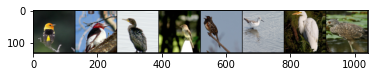

Labels:Western Tanager (Breeding Male), Red-headed Woodpecker (Adult), Double-crested Cormorant (Immature), Eastern Phoebe, Spotted Towhee, Wilson's Phalarope (Nonbreeding, juvenile), Great Egret, Yellow-crowned Night-Heron (Immature)


In [ ]:
dataiter = iter(data['train'])
images, labels = dataiter.next()
images = images[:8]
print(images.size())

def imshow(img):
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

# show images
imshow(torchvision.utils.make_grid(images))
# print labels
print("Labels:" + ', '.join('%9s' % data['to_name'][labels[j].item()] for j in range(8)))

# Model Setup

Sets up helper functions for model loading and training. These methods are copied from the [PyTorch tutorial on finetuning pretrained models](https://pytorch.org/tutorials/beginner/finetuning_torchvision_models_tutorial.html). Slight modifications were made for this project.

In [ ]:
def train_model(model, dataloaders, criterion, optimizer, num_epochs=25, state=None, is_inception=False):
    since = time.time()
    epoch_interval = time.time()
    start_epoch = 0

    hist = {
        'train': [],
        'val': []
    }

    # Load previous training state
    if state:
        model.load_state_dict(state['net'])
        optimizer.load_state_dict(state['optimizer'])
        start_epoch = state['epoch']

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    for epoch in range(start_epoch, start_epoch + num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1 + start_epoch))
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data.
            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    # Get model outputs and calculate loss
                    # Special case for inception because in training it has an auxiliary output. In train
                    #   mode we calculate the loss by summing the final output and the auxiliary output
                    #   but in testing we only consider the final output.
                    outputs = model(inputs)

                    loss = criterion(outputs, labels)

                    _, preds = torch.max(outputs, 1)

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)

            epoch_loss = running_loss / len(dataloaders[phase].dataset)
            epoch_acc = running_corrects.double() / len(dataloaders[phase].dataset)

            print('{} Loss: {:.4f} Acc: {:.4f}'.format(phase, epoch_loss, epoch_acc))

            # deep copy the model
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())

            hist[phase].append(epoch_acc)

            epoch_time_elapsed = time.time() - epoch_interval
            print(phase + 'complete in {:.0f}m {:.0f}s'.format(epoch_time_elapsed // 60, epoch_time_elapsed % 60))
            epoch_interval = time.time()

        print()

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc: {:4f}'.format(best_acc))

    # load best model weights
    model.load_state_dict(best_model_wts)
    return model, hist

In [ ]:
def set_parameter_requires_grad(model, feature_extracting):
    if feature_extracting:
        for param in model.parameters():
            param.requires_grad = False

In [ ]:
# Model Selection

def initialize_model(model_name, num_classes, feature_extract, use_pretrained=True):
    # Initialize these variables which will be set in this if statement. Each of these
    #   variables is model specific.
    model_ft = None

    if model_name == "resnet":
        """ Resnet18
        """
        model_ft = models.resnet18(pretrained=use_pretrained)
        set_parameter_requires_grad(model_ft, feature_extract)
        num_ftrs = model_ft.fc.in_features
        model_ft.fc = nn.Linear(num_ftrs, num_classes)

    elif model_name == "alexnet":
        """ Alexnet
        """
        model_ft = models.alexnet(pretrained=use_pretrained)
        set_parameter_requires_grad(model_ft, feature_extract)
        num_ftrs = model_ft.classifier[6].in_features
        model_ft.classifier[6] = nn.Linear(num_ftrs,num_classes)

    elif model_name == "vgg":
        """ VGG11_bn
        """
        model_ft = models.vgg11_bn(pretrained=use_pretrained)
        set_parameter_requires_grad(model_ft, feature_extract)
        num_ftrs = model_ft.classifier[6].in_features
        model_ft.classifier[6] = nn.Linear(num_ftrs,num_classes)

    elif model_name == "squeezenet":
        """ Squeezenet
        """
        model_ft = models.squeezenet1_0(pretrained=use_pretrained)
        set_parameter_requires_grad(model_ft, feature_extract)
        model_ft.classifier[1] = nn.Conv2d(512, num_classes, kernel_size=(1,1), stride=(1,1))
        model_ft.num_classes = num_classes

    elif model_name == "densenet":
        """ Densenet
        """
        model_ft = models.densenet121(pretrained=use_pretrained)
        set_parameter_requires_grad(model_ft, feature_extract)
        num_ftrs = model_ft.classifier.in_features
        model_ft.classifier = nn.Linear(num_ftrs, num_classes)
        
    elif model_name == "wide-resnet":
        """ Wide Resnet-50
        """
        model_ft = wide_resnet50_2 = models.wide_resnet50_2(pretrained=use_pretrained)
        set_parameter_requires_grad(model_ft, feature_extract)
        num_ftrs = model_ft.fc.in_features
        model_ft.classifier = nn.Linear(num_ftrs, num_classes)
    else:
        print("Invalid model name, exiting...")
        exit()

    return model_ft

model_ft = initialize_model(model_name, num_classes, feature_extract, use_pretrained=True)

In [ ]:
# Detect if we have a GPU available
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# Send the model to GPU
model_ft = model_ft.to(device)

# Gather the parameters to be optimized/updated in this run. If we are
#  finetuning we will be updating all parameters. However, if we are
#  doing feature extract method, we will only update the parameters
#  that we have just initialized, i.e. the parameters with requires_grad
#  is True.
params_to_update = model_ft.parameters()
print("Params to learn:")
if feature_extract:
    params_to_update = []
    for name,param in model_ft.named_parameters():
        if param.requires_grad == True:
            params_to_update.append(param)
            print("\t",name)
else:
    for name,param in model_ft.named_parameters():
        if param.requires_grad == True:
            print("\t",name)

# Observe that all parameters are being optimized
optimizer_ft = optim.SGD(params_to_update, lr=LEARNING_RATE, momentum=MOMENTUM, weight_decay=WEIGHT_DECAY)

Params to learn:
	 features.0.weight
	 features.0.bias
	 features.1.weight
	 features.1.bias
	 features.4.weight
	 features.4.bias
	 features.5.weight
	 features.5.bias
	 features.8.weight
	 features.8.bias
	 features.9.weight
	 features.9.bias
	 features.11.weight
	 features.11.bias
	 features.12.weight
	 features.12.bias
	 features.15.weight
	 features.15.bias
	 features.16.weight
	 features.16.bias
	 features.18.weight
	 features.18.bias
	 features.19.weight
	 features.19.bias
	 features.22.weight
	 features.22.bias
	 features.23.weight
	 features.23.bias
	 features.25.weight
	 features.25.bias
	 features.26.weight
	 features.26.bias
	 classifier.0.weight
	 classifier.0.bias
	 classifier.3.weight
	 classifier.3.bias
	 classifier.6.weight
	 classifier.6.bias


# Run Training

Trains the model, outputs a training / validation accuracy graph and saves the model to disk.

In [ ]:
# Setup the loss fxn
criterion = nn.CrossEntropyLoss()

# Load and train model
# state = torch.load(models_filepath + f'{model_name}_checkpoint-30.pkl')
# model_ft, hist = train_model(model_ft, data, criterion, optimizer_ft, num_epochs=num_epochs, state=state)

# Train and evaluate on fresh model
model_ft, hist = train_model(model_ft, data, criterion, optimizer_ft, num_epochs=num_epochs)

Epoch 0/29
----------
train Loss: 4.9206 Acc: 0.1070
traincomplete in 7m 26s
val Loss: 3.0994 Acc: 0.3153
valcomplete in 0m 46s

Epoch 1/29
----------
train Loss: 2.8458 Acc: 0.3363
traincomplete in 7m 20s
val Loss: 2.2540 Acc: 0.4478
valcomplete in 0m 47s

Epoch 2/29
----------
train Loss: 2.1840 Acc: 0.4568
traincomplete in 7m 20s
val Loss: 1.9952 Acc: 0.5006
valcomplete in 0m 47s

Epoch 3/29
----------
train Loss: 1.8257 Acc: 0.5288
traincomplete in 7m 20s
val Loss: 1.7812 Acc: 0.5385
valcomplete in 0m 47s

Epoch 4/29
----------
train Loss: 1.5886 Acc: 0.5808
traincomplete in 7m 19s
val Loss: 1.7074 Acc: 0.5445
valcomplete in 0m 46s

Epoch 5/29
----------
train Loss: 1.4105 Acc: 0.6180
traincomplete in 7m 19s
val Loss: 1.6328 Acc: 0.5764
valcomplete in 0m 47s

Epoch 6/29
----------
train Loss: 1.2584 Acc: 0.6562
traincomplete in 7m 18s
val Loss: 1.6305 Acc: 0.5753
valcomplete in 0m 47s

Epoch 7/29
----------
train Loss: 1.1447 Acc: 0.6823
traincomplete in 7m 19s
val Loss: 1.5714 Acc

Model: vgg
Batch Size: 128
Weight Decay: 0.001
Momentum: 0.9
Learning Rate: 0.002


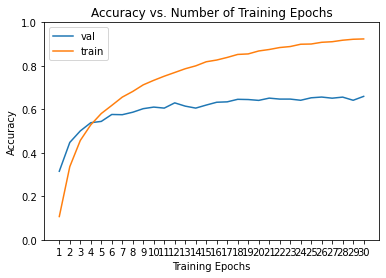

In [ ]:
# Print params
print(f'Model: {model_name}')
print(f'Batch Size: {batch_size}')
print(f'Weight Decay: {WEIGHT_DECAY}')
print(f'Momentum: {MOMENTUM}')
print(f'Learning Rate: {LEARNING_RATE}')

# Plot results
plt.title("Accuracy vs. Number of Training Epochs")
plt.xlabel("Training Epochs")
plt.ylabel("Accuracy")
plt.plot(range(1,num_epochs+1), hist['val'], label='val')
plt.plot(range(1,num_epochs+1), hist['train'], label='train')
plt.ylim((0,1.))
plt.xticks(np.arange(1, num_epochs+1, 1.0))
plt.legend()
plt.show()

In [ ]:
# Save model
state = {'epoch': num_epochs, 'net': model_ft.state_dict(), 'optimizer': optimizer_ft.state_dict(), 'model_type': model_name}
torch.save(state, models_filepath + f'{model_name}_checkpoint-30-[VG-7].pkl')

# Ensemble

Creates an ensemble of multiple models used for predicting labels.

In [ ]:
# Initialize models
def load_and_initalize(m_name, m_type):
    m_filepath = f'{models_filepath}{m_name}.pkl'
    m = initialize_model(m_type, num_classes, feature_extract)
    m.load_state_dict(torch.load(m_filepath)['net'])
    m.to(device)
    m.eval()
    return m

# Models
model_names = ['VG-5', 'VG-6', 'VG-8', 'RN-7', 'SN-3', 'DN-5']
model_types = ['vgg', 'vgg', 'vgg', 'resnet', 'squeezenet', 'densenet']
models_arr = []

for m_name, m_type in tqdm(zip(model_names, model_types)):
    models_arr.append(load_and_initalize(m_name, m_type))


0it [00:00, ?it/s]
1it [00:12, 12.07s/it]
2it [00:31, 14.17s/it]
3it [01:02, 19.38s/it]Downloading: "https://download.pytorch.org/models/resnet18-5c106cde.pth" to /root/.cache/torch/hub/checkpoints/resnet18-5c106cde.pth



4it [01:07, 14.92s/it]Downloading: "https://download.pytorch.org/models/squeezenet1_0-a815701f.pth" to /root/.cache/torch/hub/checkpoints/squeezenet1_0-a815701f.pth



5it [01:08, 10.73s/it]Downloading: "https://download.pytorch.org/models/densenet121-a639ec97.pth" to /root/.cache/torch/hub/checkpoints/densenet121-a639ec97.pth



6it [01:12, 12.03s/it]


In [ ]:
def ensemble_prediction(images):
    outputs_total = torch.tensor(np.zeros((images.shape[0], num_classes))).to(device)
    for model, weight in zip(models_arr, models_weights):
        outputs = model(images)
        outputs_total += weight * outputs
    
    return outputs_total

In [ ]:
def test_ensemble_prediction(dataloaders, criterion, phase):
    running_loss = 0.0
    running_corrects = 0

    # Iterate over data.
    for inputs, labels in tqdm(dataloaders[phase], position=0, leave=True):
        inputs = inputs.to(device)
        labels = labels.to(device)

        with torch.no_grad():
            outputs = ensemble_prediction(inputs)

            loss = criterion(outputs, labels)

            _, preds = torch.max(outputs, 1)

        # statistics
        running_loss += loss.item() * inputs.size(0)
        running_corrects += torch.sum(preds == labels.data)

    epoch_loss = running_loss / len(dataloaders[phase].dataset)
    epoch_acc = running_corrects.double() / len(dataloaders[phase].dataset)

    print('\n{} Loss: {:.4f} Acc: {:.4f}\n'.format(phase, epoch_loss, epoch_acc))
    
    # Print weights
    for model, weight in zip(model_names, models_weights):
        print(f'{model}: {weight}')

In [ ]:
models_weights = [0.2, 0.3, 0.1, 0.1, 0.15, 0.2]
criterion = nn.CrossEntropyLoss()
test_ensemble_prediction(data, criterion, 'val')

100%|██████████| 31/31 [00:50<00:00,  1.64s/it]


val Loss: 0.2850 Acc: 0.9427

VG-5: 0.2
VG-6: 0.3
VG-8: 0.1
RN-7: 0.1
SN-3: 0.15
DN-5: 0.2


# Classify Test

Classifies the test set and outputs the predictions in a `.csv` file.

In [ ]:
def predict(dataloader, ofname):
    out = open(ofname, 'w')
    out.write("path,class\n")
    # net.to(device)
    # net.eval()

    with torch.no_grad():
        for i, (images, labels) in tqdm(enumerate(dataloader, 0), position=0, leave=True, total=10000):
            images, labels = images.to(device), labels.to(device)
            outputs = ensemble_prediction(images)
            _, predicted = torch.max(outputs.data, 1) 
            fname, _ = dataloader.dataset.samples[i]
            out.write("test/{},{}\n".format(fname.split('/')[-1], data['to_class'][predicted.item()]))
    out.close()

In [ ]:
predict(data['test'], test_output_filepath + f"E2-8.csv")

100%|██████████| 10000/10000 [05:12<00:00, 32.03it/s]
